In [1]:
import rdkit
import pandas as pd
import torch
from rdkit import Chem
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
#IPythonConsole.ipython_useSVG=True
from captum.attr import *
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.utils import accuracy, f1_score
device = 'cpu'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TopKPooling, SAGEConv, EdgePooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp


RDKit WARNING: [17:34:25] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
class Net(nn.Module):
    
    def __init__(self, n_feats):
        super(Net, self).__init__()
        self.atom_embedding = nn.Linear(n_feats, n_feats)
        self.conv1 = SAGEConv(n_feats, n_feats)
        self.pool1 = EdgePooling(n_feats)
        self.conv2 = SAGEConv(n_feats, n_feats)
        self.pool2 = EdgePooling(n_feats)
        self.linear = torch.nn.Linear(2*n_feats, 1)

    def forward(self, x, edge_index, batch=None):
        if len(x.shape) == 3: #NEEDED FOR EXAI, NOTICE THAT IT MUST BE ONLY ONE MOL
            data_list = []
            for x_i, edge_index_i in zip(x, edge_index):
                data_list.append(Data(x=x_i, edge_index=edge_index_i))
            data = Batch.from_data_list(data_list).to(device)
            x = data.x
            batch = data.batch
            edge_index = data.edge_index
        shape = x.shape
        x = x.reshape(-1,shape[-1])
        x = self.atom_embedding(x)
        x = x.reshape(shape)
        x = x.squeeze(1)
        
        x = F.relu(self.conv1(x, edge_index))

        x, edge_index, batch, _ = self.pool1(x, edge_index, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        x, edge_index, batch, _ = self.pool2(x, edge_index, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        x = x1 + x2
        x = self.linear(x)    
        #x = torch.sigmoid(x)
        x = x.squeeze(1)
        return x



In [3]:
import numpy as np


        
    
    

In [4]:
!ls

 antiviral_with_properties.sdf_.zip
 CHEMBL_HDAC1_B-r3_b2048.csv
 Compound_000000001_000500000.xml.gz
 GraphNN_Solubility.ipynb
 GraphNN_SPIKE.ipynb
 gt_model
 gt_model_logp
 HDAC4_bioactivity-18_18_17_29_IC50.csv
 jak2_data.csv
 logP_dataset.csv
 merge_mols.py
'PREDICTION OF PKA FROM CHEMICAL STRUCTURE USING FREE AND OPEN-SOURCE TOOLS_KM_AJW.PDF'
 PROTACXN_P59594_bioactivity_protein.csv
 solubility_data.csv
 SPIKE_DATA.csv
 untitled.csv


In [68]:
#df = pd.read_csv('CHEMBL_HDAC1_B-r3_b2048.csv')
df = pd.read_csv('covid_chembl_1700.csv', header = 0, sep=';')
# df.columns = ['SMILES', 'logP']

In [103]:
df

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,act,SMILES,mol,graph
0,CHEMBL416230,DECOQUINATE,0,417.55,1,6.04,decoquinate,CCCCCCCCCCOc1cc2c(O)c(C(=O)OCC)cnc2cc1OCC,Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.058900,CCCCCCCCCCOc1cc2c(O)c(C(=O)OCC)cnc2cc1OCC,<rdkit.Chem.rdchem.Mol object at 0x7f78ab9c3760>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
1,CHEMBL556,DEFEROXAMINE,4,560.69,2,0.92,Deferoxamine,CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...,Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,-0.000062,CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...,<rdkit.Chem.rdchem.Mol object at 0x7f78ab9c38f0>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 3,..."
2,CHEMBL1200980,ESTROPIPATE,4,436.57,0,3.29,estropipate,C1CNCCN1.C[C@]12CC[C@@H]3c4ccc(OS(=O)(=O)O)cc4...,Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.146400,C1CNCCN1.C[C@]12CC[C@@H]3c4ccc(OS(=O)(=O)O)cc4...,<rdkit.Chem.rdchem.Mol object at 0x7f78ab9c3580>,"[(edge_index, [tensor([ 0, 0, 1, 1, 2, 2,..."
3,CHEMBL173562,NaN,0,182.17,0,0.54,2-hydroxyethyl-salicylate,O=C(OCCO)c1ccccc1O,Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.157000,O=C(OCCO)c1ccccc1O,<rdkit.Chem.rdchem.Mol object at 0x7f78ab9c3b20>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 2,..."
5,CHEMBL185,FLUOROURACIL,4,130.08,0,-0.80,5-FU,O=c1[nH]cc(F)c(=O)[nH]1,Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.236900,O=c1[nH]cc(F)c(=O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7f78ab9c36c0>,"[(edge_index, [tensor([0, 1, 1, 1, 2, 2, 3, 3,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,CHEMBL1337,NITISINONE,4,329.23,0,2.73,Nitisinone,O=C1CCCC(=O)C1C(=O)c1ccc(C(F)(F)F)cc1[N+](=O)[O-],Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.298100,O=C1CCCC(=O)C1C(=O)c1ccc(C(F)(F)F)cc1[N+](=O)[O-],<rdkit.Chem.rdchem.Mol object at 0x7f78ab6feb20>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 2,..."
1665,CHEMBL620,CLIDINIUM,4,352.45,0,2.70,clidinium,C[N+]12CCC(CC1)C(OC(=O)C(O)(c1ccccc1)c1ccccc1)C2,Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.116000,C[N+]12CCC(CC1)C(OC(=O)C(O)(c1ccccc1)c1ccccc1)C2,<rdkit.Chem.rdchem.Mol object at 0x7f78ab6feb70>,"[(edge_index, [tensor([ 0, 1, 1, 1, 1, 2,..."
1666,CHEMBL566,URACIL,3,112.09,0,-0.94,Uracil,O=c1cc[nH]c(=O)[nH]1,Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.202800,O=c1cc[nH]c(=O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7f78ab6febc0>,"[(edge_index, [tensor([0, 1, 1, 1, 2, 2, 3, 3,..."
1667,CHEMBL114655,NYLIDRIN,0,299.41,0,3.43,Nylidrin,CC(CCc1ccccc1)NC(C)C(O)c1ccc(O)cc1,Hit score,'=',...,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,-0.044700,CC(CCc1ccccc1)NC(C)C(O)c1ccc(O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f78ab6fec10>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 2,..."


<AxesSubplot:>

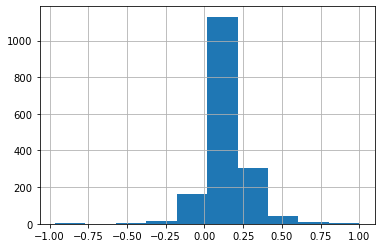

In [81]:
df['Standard Value'].hist()

In [82]:
import matplotlib.pyplot as plt
#plt.hist(df.pIC50)
#df['act'] = (df.pIC50 > 8.2)*1.0
#df['act'] = (df.logP >= 1) & (df['logP'] <= 4 )
df['act'] = df['Standard Value']
df['SMILES'] = df.Smiles

In [83]:
#df['act'] = df['IS_ACTIVE']

In [84]:
#df['SMILES'] = df['Smiles']
#df = df.dropna()

In [85]:
def try_catch(fn, *args, **kwargs):
    try:
        return fn(*args, **kwargs)
    except Exception as e:
        print(e, *args, **kwargs)
        return None

In [86]:
df.head(15)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,act,SMILES,mol
0,CHEMBL416230,DECOQUINATE,0,417.55,1,6.04,decoquinate,CCCCCCCCCCOc1cc2c(O)c(C(=O)OCC)cnc2cc1OCC,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.058900,CCCCCCCCCCOc1cc2c(O)c(C(=O)OCC)cnc2cc1OCC,<rdkit.Chem.rdchem.Mol object at 0x7f78abf55490>
1,CHEMBL556,DEFEROXAMINE,4,560.69,2,0.92,Deferoxamine,CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,-0.000062,CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...,<rdkit.Chem.rdchem.Mol object at 0x7f78abf63620>
2,CHEMBL1200980,ESTROPIPATE,4,436.57,0,3.29,estropipate,C1CNCCN1.C[C@]12CC[C@@H]3c4ccc(OS(=O)(=O)O)cc4...,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.146400,C1CNCCN1.C[C@]12CC[C@@H]3c4ccc(OS(=O)(=O)O)cc4...,<rdkit.Chem.rdchem.Mol object at 0x7f78abf63670>
3,CHEMBL173562,NaN,0,182.17,0,0.54,2-hydroxyethyl-salicylate,O=C(OCCO)c1ccccc1O,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.157000,O=C(OCCO)c1ccccc1O,<rdkit.Chem.rdchem.Mol object at 0x7f78abf63710>
4,CHEMBL4303162,NaN,0,None,None,None,7de5b5c6-cb03-4f69-b32d-738c306fa726,NaN,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.019940,NaN,None
5,CHEMBL185,FLUOROURACIL,4,130.08,0,-0.80,5-FU,O=c1[nH]cc(F)c(=O)[nH]1,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.236900,O=c1[nH]cc(F)c(=O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7f78abf637b0>
6,CHEMBL593429,ALLANTOIN,0,158.12,0,-2.18,allantoin,NC(=O)NC1NC(=O)NC1=O,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.164600,NC(=O)NC1NC(=O)NC1=O,<rdkit.Chem.rdchem.Mol object at 0x7f78abf63760>
7,CHEMBL253371,ALVERINE,4,281.44,0,4.57,Alverine,CCN(CCCc1ccccc1)CCCc1ccccc1,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.351500,CCN(CCCc1ccccc1)CCCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f78abf63800>
8,CHEMBL354077,AMIFAMPRIDINE,4,109.13,0,0.25,Amifampridine,Nc1ccncc1N,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.160300,Nc1ccncc1N,<rdkit.Chem.rdchem.Mol object at 0x7f78abf63850>
9,CHEMBL1077,BROMFENAC,4,334.17,0,2.89,Bromfenac,Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1,Hit score,'=',...,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.214800,Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f78abf638a0>


In [89]:
CHIRAL_TYPES = len(Chem.rdchem.ChiralType.values)
HYBRIDIZATION_TYPES = len(Chem.rdchem.HybridizationType.values)
atoms = [1,3,5,6,7,8,9,11,13,14,15,16,17,19,20,25,26,27,30,33,34,35,38,42,47,50,53, 78, 79, 80,83]
seen_atoms = {k:i for i, k in enumerate(sorted(atoms))}

def atm_data(atm):
    atomic_num = atm.GetAtomicNum()
    atomic_num = np.eye(len(seen_atoms))[seen_atoms[atomic_num]]
    chiral = np.eye(CHIRAL_TYPES)[int(atm.GetChiralTag())]
    hybrid = np.eye(HYBRIDIZATION_TYPES)[int(atm.GetHybridization())]
    charge = atm.GetFormalCharge()
    imp_val = atm.GetImplicitValence()
    aromatic = int(atm.GetIsAromatic())
    isotope = atm.GetIsotope()
    mass = atm.GetMass()
    rad_ele = atm.GetNumRadicalElectrons()
    ring = atm.IsInRing()
    data = np.concatenate([atomic_num, [charge,imp_val, aromatic, isotope, mass, rad_ele, ring], chiral, hybrid])
    return data

def gen_graph(mol, act=None):
    #print(act)
    n = mol.GetNumAtoms()
    atoms = []
    #adj = np.zeros((n,n))
    edge_index = []
    for atm in mol.GetAtoms():
        atoms.append(atm_data(atm))
        idx = atm.GetIdx()
        for neig in atm.GetNeighbors():
            neig_idx = neig.GetIdx()
            #adj[idx, neig_idx] = 1
            #adj[neig_idx, idx] = 1
            edge_index.append([idx, neig_idx])
    edge_index = torch.tensor(np.transpose(edge_index)).long()
    #print(edge_index)
    x = torch.tensor(np.array(atoms)).float()
    if act is not None:
        act = torch.tensor([act]).float()
    data = Data(x=x, edge_index=edge_index, y=act)
    return data
df['mol'] = df.apply(lambda row: try_catch(Chem.MolFromSmiles, row['SMILES']), axis=1)
df = df.dropna(subset=['mol'])
df['graph'] = df.apply(lambda row: gen_graph(row['mol'], row['act']), axis=1)
#df['graph'] = df.apply(gen_graph)


No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered conver

/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [90]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, shuffle=True)
df_train = df
df_test = df

In [91]:
train_data = list(df_train.graph)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_data = list(df_test.graph)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [92]:
net = Net(19+len(atoms))
net = net.to(device)
#loss = nn.BCELoss()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
EPOCHS = 70

In [93]:
losses = []
print('loss, acc, f1')
for epoch in range(EPOCHS):
    net.train()
    stats = np.zeros(3)
    for data in train_loader:
        data = data.to(device)
        x, edge_index, batch = data.x, data.edge_index, data.batch
        y_pred = net(x, edge_index, batch)
        y = data.y.to(device)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        stats += data.num_graphs * np.array([l.item(), 0, 0])
#         stats += data.num_graphs * np.array([l.item(),accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
        #stats += data.num_graphs * np.array([l.item()])#,accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])

    losses.append(stats/len(train_data))
    print('train', losses[-1])
    net.eval()
    stats = np.zeros(3)
    for data in test_loader:
        with torch.no_grad():
            data = data.to(device)
            x, edge_index, batch = data.x, data.edge_index, data.batch
            y_pred = net(x, edge_index, batch)
            y = data.y.to(device)
            l = loss(y_pred, y)
            stats += data.num_graphs * np.array([l.item(), 0, 0])
#             stats += data.num_graphs * np.array([l.item(),accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
            #stats += data.num_graphs * np.array([l.item()])#,accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
    losses.append(stats/len(test_data))
    print('test', losses[-1])

loss, acc, f1
train [3.91145629 0.         0.        ]
test [0.46664507 0.         0.        ]
train [0.20547941 0.         0.        ]
test [0.0367039 0.        0.       ]
train [0.06834788 0.         0.        ]
test [0.02459272 0.         0.        ]
train [0.04178912 0.         0.        ]
test [0.02507373 0.         0.        ]
train [0.0272595 0.        0.       ]
test [0.02475565 0.         0.        ]
train [0.02195077 0.         0.        ]
test [0.02267915 0.         0.        ]
train [0.02102099 0.         0.        ]
test [0.01950086 0.         0.        ]
train [0.01990328 0.         0.        ]
test [0.01948468 0.         0.        ]
train [0.01927924 0.         0.        ]
test [0.01937991 0.         0.        ]
train [0.01927003 0.         0.        ]
test [0.01910934 0.         0.        ]
train [0.01907861 0.         0.        ]
test [0.01909555 0.         0.        ]
train [0.0190625 0.        0.       ]
test [0.01902994 0.         0.        ]
train [0.01903309 0.   

KeyboardInterrupt: 

In [94]:
net

Net(
  (atom_embedding): Linear(in_features=50, out_features=50, bias=True)
  (conv1): SAGEConv(50, 50)
  (pool1): EdgePooling(50)
  (conv2): SAGEConv(50, 50)
  (pool2): EdgePooling(50)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [95]:
torch.save(net, 'gt_model_covid')

In [96]:
def visualize(smiles_list, net, method, ys=None, display=False):
    explains = []
    th_min = float('inf')
    th_max = -float('inf')
    acts = []
    mols = []
    
    explainator = method(net) 
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        data = gen_graph(mol)
        attributions = explainator.attribute(data.x.unsqueeze(0).to(device),
                                                         #baselines=torch.zeros_like(data.x).unsqueeze(0).to(device),
                                                         additional_forward_args=(data.edge_index.unsqueeze(0).to(device),),
                                                         #method='gausslegendre',
                                                         #internal_batch_size=1,  #NEEDED in IG, OTHERWISE FUCKS UP
                                                       )
        explain = attributions.squeeze(0)
        batch = Batch.from_data_list([data]).to(device)
        out = net(batch.x, batch.edge_index, batch.batch)
        acts.append(out.item())
        mols.append(mol)
        explain = explain.mean(-1).detach().cpu().numpy()
        explains.append(explain)
        th_min = min(np.min(explain), th_min)
        th_max = max(np.max(explain), th_max)

    
    vmin = th_min
    vmax = th_max

    l = []
    for explain, mol in zip(explains, mols):
        explain = (explain - vmin)/(vmax - vmin) * 100

        atoms = explain
        highlightMap = {}
        for i, score in enumerate(atoms):
            r, b = 0, 0
            if score > 50:
                r = (score-50)/50
            else:
                b = score/50

            highlightMap[i] = [r, 0, b]
        #print(highlightMap)
        l.append(Draw.MolToImage(mol, size=(300, 300), highlightMap=highlightMap))
    
    if display:
        for i, (elem, act) in enumerate(zip(l, acts)):
            print(act)
            if ys:
                print(ys[i])
            display(elem)
    
    return list(zip(l, acts))

In [104]:
METHODS = {
        "Integrated Gradients": IntegratedGradients,
        "Deep Lift": DeepLift,
        "Gradients": Saliency,
        "Input X Gradients": InputXGradient,
        "Guided Backprop": GuidedBackprop,
    }
#MOLS = ['CC(C)=CCCC(C)=CC(=O)', 'CC(O)=CCCC(C)=CC=O', 'CC(C)=CCCC(C)=CC']
MOLS = ['CCCCC', 'CCCCO', 'OC(=O)CCCCO']
MOLS = [df.Smiles[5], df.Smiles[1666]]
explainations = {}
for name, method in METHODS.items():
    imgs = visualize(MOLS, net, method)
    explainations[name] = imgs

/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


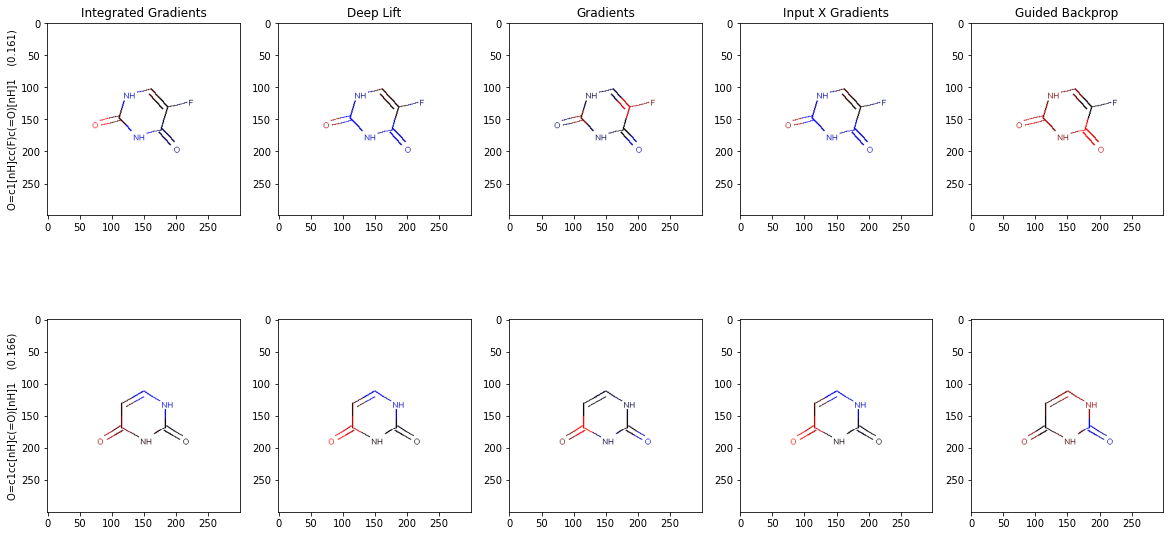

In [105]:
fig, ax = plt.subplots(len(MOLS), len(METHODS), figsize=(10*len(MOLS), 2*len(METHODS)))

for i, (name, imgs) in enumerate(explainations.items()):
    for j, (img, act) in enumerate(imgs):
        ax[j,i].imshow(img)
        ax[j,0].set_ylabel(f"{MOLS[j]}    ({act:.3})")
    ax[0,i].set_title(name)

plt.show()